In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
## from pass_k
def estimator(n: int, c: int, k: int) -> float:
    """
    Calculates 1 - comb(n - c, k) / comb(n, k).
    """
    if n - c < k:
        return 1.0
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

def evaluate_data_3(df: pd.DataFrame, k: int, print_data=True):
    # State is unhashable, so we convert it to a string
    df["state_str"] = df["state"].apply(lambda x: str(x))
    df = df[["name", "state_str", "constraint", "completion", "is_sat"]]
    
    df = df.groupby(["name", "state_str"])
    df = df.agg(c=("is_sat", pd.Series.sum),
                n=("is_sat", pd.Series.count))
    
    df["pass1"]  = df.apply(lambda row: estimator(row["n"], row["c"], 1), axis=1)
    df = df.drop(columns=["c"])

    if print_data:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(df)
    return df

def calculate_results_table(eval_df: pd.DataFrame, print_table=True):
    def normalize(row):
        row["name"] = row["name"].split("-")[0]
        return row
    
    df = eval_df.reset_index(level=[0,1])

    state_means = df.groupby(["name"])["pass1"].mean().rename("state_mean").to_frame()
    state_means.reset_index(level=[0], inplace=True)
    
    norm_state_means = state_means.apply(lambda row: normalize(row), axis=1)
    
    prompt_means = norm_state_means.groupby(["name"])["state_mean"].mean().rename("mean")
    maxes = norm_state_means.groupby(["name"])["state_mean"].max().rename("max")
    mins = norm_state_means.groupby(["name"])["state_mean"].min().rename("min")

    results = pd.concat([maxes, mins, prompt_means], axis=1)
    
    results["+-"] = results.apply(lambda row: max(row["max"] - row["mean"],
                                                     row["mean"] - row["min"]), axis=1)
    results = results.apply(lambda row: round(row, 3))
    results = results.reset_index(level=[0])
    if print_table:
        print(results)
    return results

In [3]:
palm_df = pd.read_json(open("palm_eval.jsonl","r"), lines=True)
palm_df3 = evaluate_data_3(palm_df, 1, print_data=False)
palm_res = calculate_results_table(palm_df3, print_table=False)

gpt_df = pd.read_json(open("gpt_eval.jsonl","r"), lines=True)
gpt_df3 = evaluate_data_3(gpt_df, 1, print_data=False)
gpt_res = calculate_results_table(gpt_df3, print_table=False)

star_df = pd.read_json(open("starcoder_eval.jsonl","r"), lines=True)
star_df3 = evaluate_data_3(star_df, 1, print_data=False)
star_res = calculate_results_table(star_df3, print_table=False)

In [4]:
star_df3["model"] = "StarCoder"
star_df3.head()
gpt_df3["model"] = "GPT3.5"
gpt_df3.head()
palm_df3["model"] = "Palm" 
palm_df3.head()

frames = [star_df3, gpt_df3, palm_df3]

results = pd.concat(frames).reset_index()
results.head(-1)

,name,state_str,n,pass1,model
0,ElevatorTour-0,"{'locations': ['elevator', 'main conference ro...",20,1.00,StarCoder
1,ElevatorTour-0,"{'locations': ['elevator', 'main conference ro...",20,0.05,StarCoder
2,ElevatorTour-0,"{'locations': ['elevator', 'main conference ro...",20,1.00,StarCoder
3,ElevatorTour-1,"{'locations': ['elevator', 'main conference ro...",20,1.00,StarCoder
4,ElevatorTour-1,"{'locations': ['elevator', 'main conference ro...",20,0.00,StarCoder
...,...,...,...,...,...
189,StaplerSupply-3,"{'locations': ['printer room 1', 'living room'...",20,0.70,Palm
190,StaplerSupply-3,"{'locations': ['printer room 1', 'living room'...",20,0.70,Palm
191,StaplerSupply-3,"{'locations': ['printer room 1', 'living room'...",20,0.70,Palm
192,StaplerSupply-4,"{'locations': ['printer room 1', 'living room'...",20,0.00,Palm


In [109]:
results["name"] = results['name'].str.split('-').str[0]
results['name'] = pd.Categorical(results.name, categories=['LunchBreak', 'StaplerSupply', 'MovieMessenger', 'ElevatorTour', 'HalloweenList'], ordered=True)
results.sort_values('name')
results.head()

,name,state_str,n,pass1,model
0,ElevatorTour,"{'locations': ['elevator', 'main conference ro...",20,1.00,StarCoder
1,ElevatorTour,"{'locations': ['elevator', 'main conference ro...",20,0.05,StarCoder
2,ElevatorTour,"{'locations': ['elevator', 'main conference ro...",20,1.00,StarCoder
3,ElevatorTour,"{'locations': ['elevator', 'main conference ro...",20,1.00,StarCoder
4,ElevatorTour,"{'locations': ['elevator', 'main conference ro...",20,0.00,StarCoder


In [91]:
agg = results.groupby("name")["pass1"].mean()
agg.head()

name
LunchBreak        0.258333
StaplerSupply     0.573333
MovieMessenger    0.800000
ElevatorTour      0.894444
HalloweenList     0.906667
Name: pass1, dtype: float64

In [121]:
agg_df = pd.DataFrame(agg).reset_index()  # adding a row
agg_df.rename(columns={'name': 'model'}, inplace=True)
agg_df["name"] = "aggregate"
agg_df["state_str"] = " "
agg_df["n"] = "20"
agg_df.head()
#results = pd.concat([agg_df,results])

,model,pass1,name,state_str,n
0,LunchBreak,0.258333,aggregate,,20
1,StaplerSupply,0.573333,aggregate,,20
2,MovieMessenger,0.800000,aggregate,,20
3,ElevatorTour,0.894444,aggregate,,20
4,HalloweenList,0.906667,aggregate,,20


In [99]:
palm = np.array(palm_res["mean"].tolist())
palm_min = np.array(palm_res["min"].tolist())
palm_max = np.array(palm_res["max"].tolist())

starcoder = np.array(star_res["mean"].tolist())
starcoder_min = np.array(star_res["min"].tolist())
starcoder_max = np.array(star_res["max"].tolist())

gpt = np.array(gpt_res["mean"].tolist())
gpt_min = np.array(gpt_res["min"].tolist())
gpt_max = np.array(gpt_res["max"].tolist())

palm_err = abs(np.array([palm_min, palm_max]) - palm)
starcoder_err = abs(np.array([starcoder_min, starcoder_max]) - starcoder)
gpt_err = abs(np.array([gpt_min, gpt_max]) - gpt)

[Text(0.5, 0, ' '), Text(0, 0.5, 'pass@1 rate')]

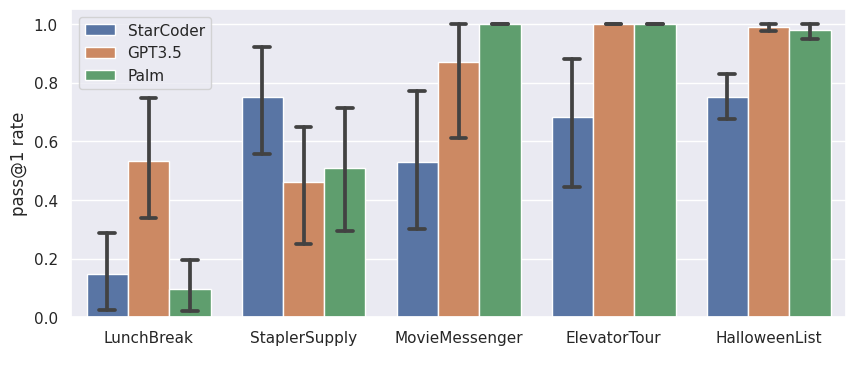

In [111]:
sns.set(rc={"figure.figsize":(10, 4)})
fig = sns.barplot(data = results, x="name", y = "pass1", capsize=.1, hue="model")
fig.legend(loc='upper left')
fig.set(xlabel=' ', ylabel='pass@1 rate')
#


[Text(0, 0, 'LunchBreak'),
 Text(1, 0, 'StaplerSupply'),
 Text(2, 0, 'MovieMessenger'),
 Text(3, 0, 'ElevatorTour'),
 Text(4, 0, 'HalloweenList')]

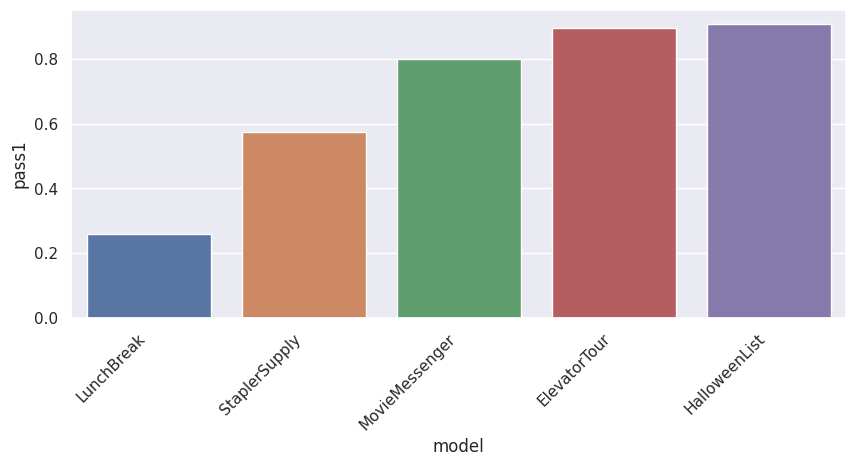

In [98]:
fig2 = sns.barplot(data=agg_df, x='model', y="pass1")
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45, horizontalalignment='right')

,is_sat,name,state,completion,model,constraint,state_str
0,False,LunchBreak-0,"{'locations': ['alice's office', 'bob's office...",\ndef task_program():\n start_loc = get_cur...,gpt3,% Ask if Alice and Bob in their offices are up...,"{'locations': [""alice's office"", ""bob's office..."
1,False,LunchBreak-0,"{'locations': ['alice's office', 'bob's office...",\ndef task_program():\n start_loc = get_cur...,gpt3,% Ask if Alice and Bob in their offices are up...,"{'locations': [""alice's office"", ""bob's office..."
2,False,LunchBreak-0,"{'locations': ['alice's office', 'bob's office...",\ndef task_program():\n start_loc = get_cur...,gpt3,% Ask if Alice and Bob in their offices are up...,"{'locations': [""alice's office"", ""bob's office..."
3,False,LunchBreak-0,"{'locations': ['alice's office', 'bob's office...",\ndef task_program():\n start_loc = get_cur...,gpt3,% Ask if Alice and Bob in their offices are up...,"{'locations': [""alice's office"", ""bob's office..."
4,False,LunchBreak-0,"{'locations': ['alice's office', 'bob's office...",\ndef task_program():\n start_loc = get_cur...,gpt3,% Ask if Alice and Bob in their offices are up...,"{'locations': [""alice's office"", ""bob's office..."


[0.148 0.7   0.33  0.016 0.15  0.09  0.25  0.37  0.034 0.2   0.   ]
[0.148  0.75   0.53   0.683  0.75   0.5722]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (6,).

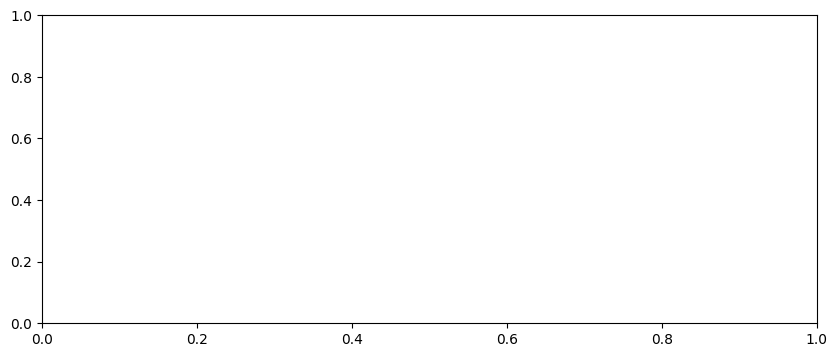

In [8]:
tasks_len = 5
palm_res['name'] = pd.Categorical(palm_res.name, categories=['LunchBreak', 'StaplerSupply', 'MovieMessenger', 'ElevatorTour', 'HalloweenList'], ordered=True)
star_res['name'] = pd.Categorical(star_res.name, categories=['LunchBreak', 'StaplerSupply', 'MovieMessenger', 'ElevatorTour', 'HalloweenList'], ordered=True)
gpt_res['name'] = pd.Categorical(gpt_res.name, categories=['LunchBreak', 'StaplerSupply', 'MovieMessenger', 'ElevatorTour', 'HalloweenList'], ordered=True)
palm_res.sort_values('name', inplace=True)
star_res.sort_values('name', inplace=True)
gpt_res.sort_values('name', inplace=True)


palm = np.array(palm_res["mean"].tolist())
palm_min = np.array(palm_res["min"].tolist())
palm_max = np.array(palm_res["max"].tolist())


starcoder = np.array(star_res["mean"].tolist())
starcoder_min = np.array(star_res["min"].tolist())
starcoder_max = np.array(star_res["max"].tolist())


gpt = np.array(gpt_res["mean"].tolist())
gpt_min = np.array(gpt_res["min"].tolist())
gpt_max = np.array(gpt_res["max"].tolist())



barWidth = 0.25
br1 = np.arange(tasks_len)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]


palm_err = abs(np.array([palm_min, palm_max]) - palm)
#palm_err = np.append(palm_err, 0)
starcoder_err = abs(np.array([starcoder_min, starcoder_max]) - starcoder)
#print(starcoder_err)
gpt_err = abs(np.array([gpt_min, gpt_max]) - gpt)
#gpt_err = np.append(gpt_err, 0)


palm = np.append(palm, np.mean(palm))
starcoder= np.append(starcoder, np.mean(starcoder))
gpt = np.append(gpt, np.mean(gpt))

print(starcoder_err)
print(starcoder)
plt.figure(figsize=[10,4])
plt.bar(br1,starcoder, color ='mediumseagreen',width = barWidth, yerr=starcoder_err, capsize=6)
plt.bar(br2,gpt, color ='cornflowerblue',width = barWidth, yerr=gpt_err, capsize=6)
plt.bar(br3,palm, color ='indianred', width = barWidth, yerr=palm_err, capsize=6)


#print(palm_res)
assert palm_res["name"].tolist() == star_res["name"].tolist() == gpt_res["name"].tolist()
assert len(palm_res["name"].tolist()) == tasks_len

plt.legend(["StarCoder", "GPT3.5", "Palm"])
plt.xticks([r + barWidth +.1 for r in range(tasks_len)],
        palm_res["name"].tolist())